In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# train = pd.read_csv('drive/MyDrive/tabular-playground-series/train.csv')
# test = pd.read_csv('drive/MyDrive/tabular-playground-series/test.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [4]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
train.drop(columns=['row_id'], inplace=True)
test.drop(columns=['row_id'], inplace=True)

In [7]:
print("Train set missing values:", train.isnull().sum().sum())
print("Test set missing values:", test.isnull().sum().sum())

Train set missing values: 0
Test set missing values: 0


In [8]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)
Duplicates in test set: 0, (0.0%)


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.7+ MB


In [10]:
train.nunique()

date        1461
country        6
store          2
product        4
num_sold     699
dtype: int64

In [11]:
def val_count_df(df, column_name, sort_by_column_name=False):
  value_count = train[column_name].value_counts().reset_index().rename(columns={column_name:'Value Count', 'index':column_name}).set_index(column_name)
  value_count['Percentage'] = train[column_name].value_counts(normalize=True)*100
  value_count = value_count.reset_index()
  if sort_by_column_name:
    value_count.sort_values(column_name)
  else:
    return value_count

def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
  val_count = val_count_df(df, column_name, sort_by_column_name)
  val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5, 5), legend=False, ylabel="")

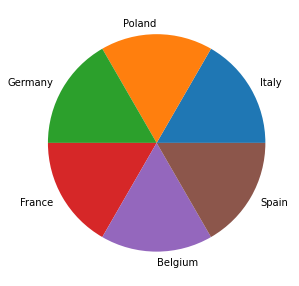

In [12]:
plot_and_display_valuecounts(train, 'country')

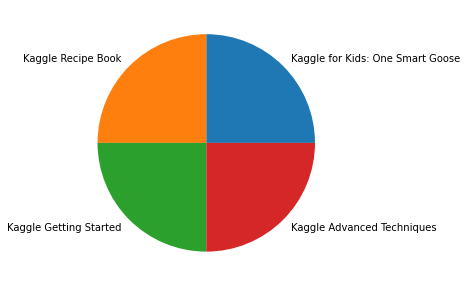

In [13]:
plot_and_display_valuecounts(train, 'product')

Every groun seems to occur in equal amounts

In [14]:
train.groupby(['country', 'store', 'product'])['num_sold'].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

In [15]:
print('Train - Earliest date', train['date'].min())
print('Train - Latest date', train['date'].max())
print('Test - Earliest date', test['date'].min())
print('Test - Latest date', test['date'].max())

Train - Earliest date 2017-01-01 00:00:00
Train - Latest date 2020-12-31 00:00:00
Test - Earliest date 2021-01-01 00:00:00
Test - Latest date 2021-12-31 00:00:00


- We have 4 years of data from 2017-01-01 to 2020-12-31 to train occuring at daily frequency
- We are reuired to forecast 1 year of data from 2021-01-01 to 2021-12-31

In [16]:
# weekly_df = train.groupby(['country', 'store', 'product', pd.Grouper(key='date', freq='W')])['num_sold'].sum()
# weekly_df
weekly_df = train.groupby(['country', 'store', 'product', pd.Grouper(key='date', freq='W')])['num_sold'].sum().rename('num_sold').reset_index()
weekly_df
monthly_df = train.groupby(['country', 'store', 'product', pd.Grouper(key='date', freq='M')])['num_sold'].sum().rename("num_sold").reset_index()
weekly_df.head()
monthly_df.head()

,country,store,product,date,num_sold
0,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-31,13345
1,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-02-28,12556
2,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-03-31,14137
3,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-04-30,14575
4,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-05-31,14338


In [17]:
def plot_all(df):
    f, axes = plt.subplots(2,2, figsize=(20, 15), sharex=True, sharey=True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store", ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

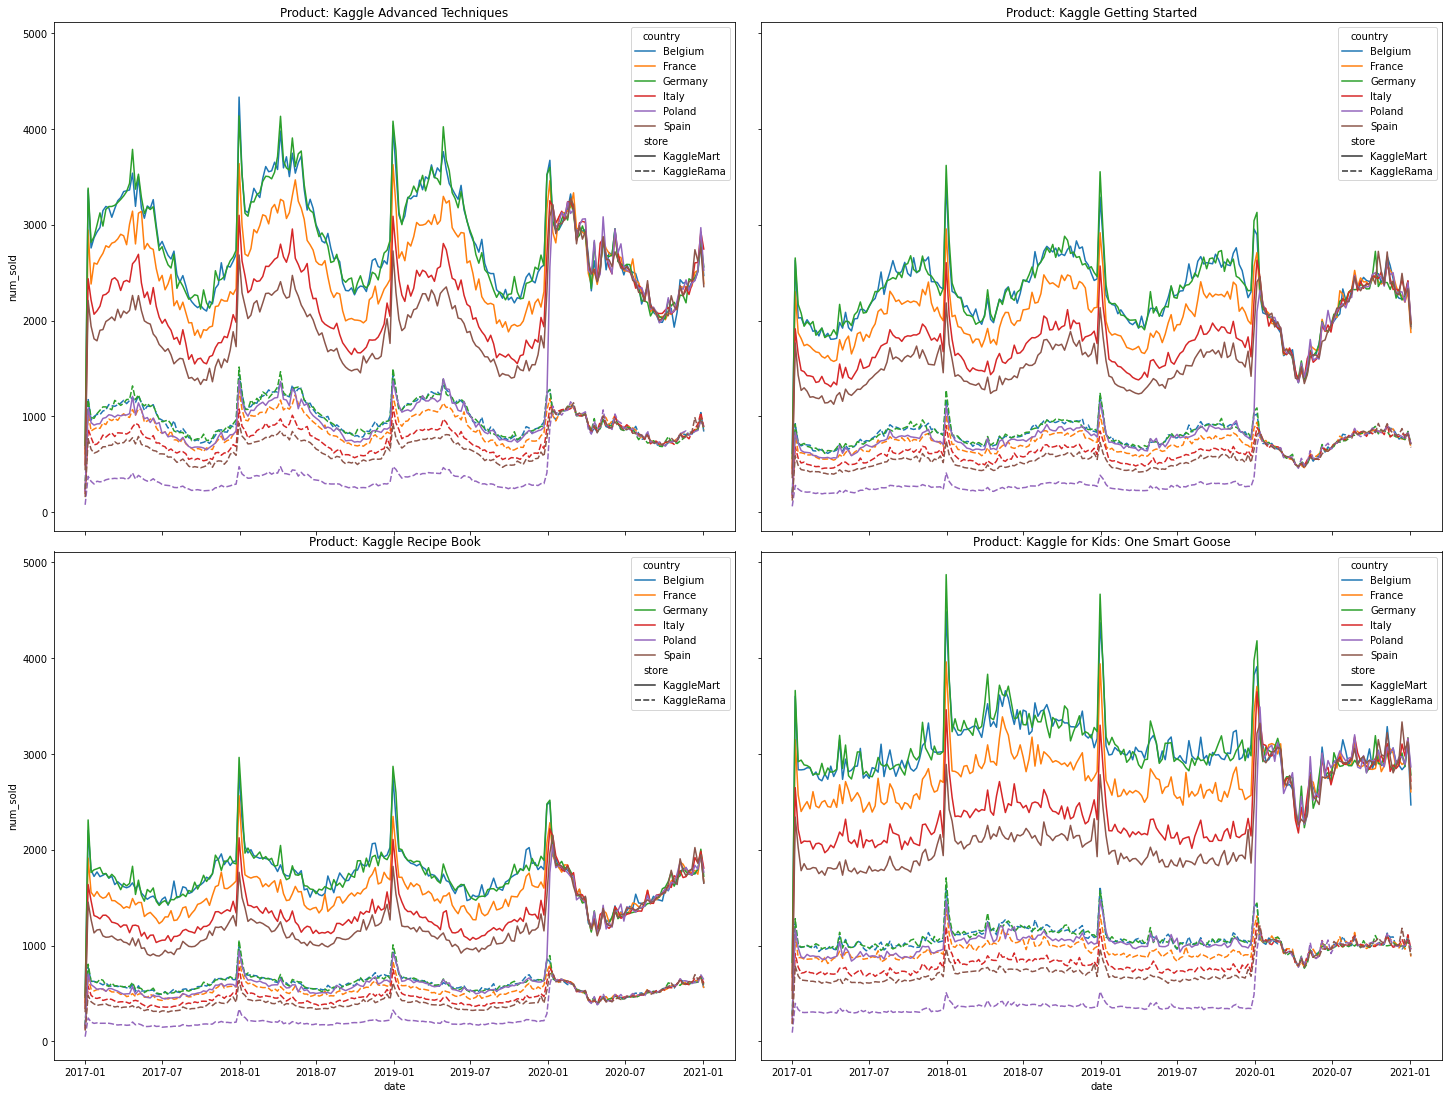

In [19]:
plot_all(weekly_df)

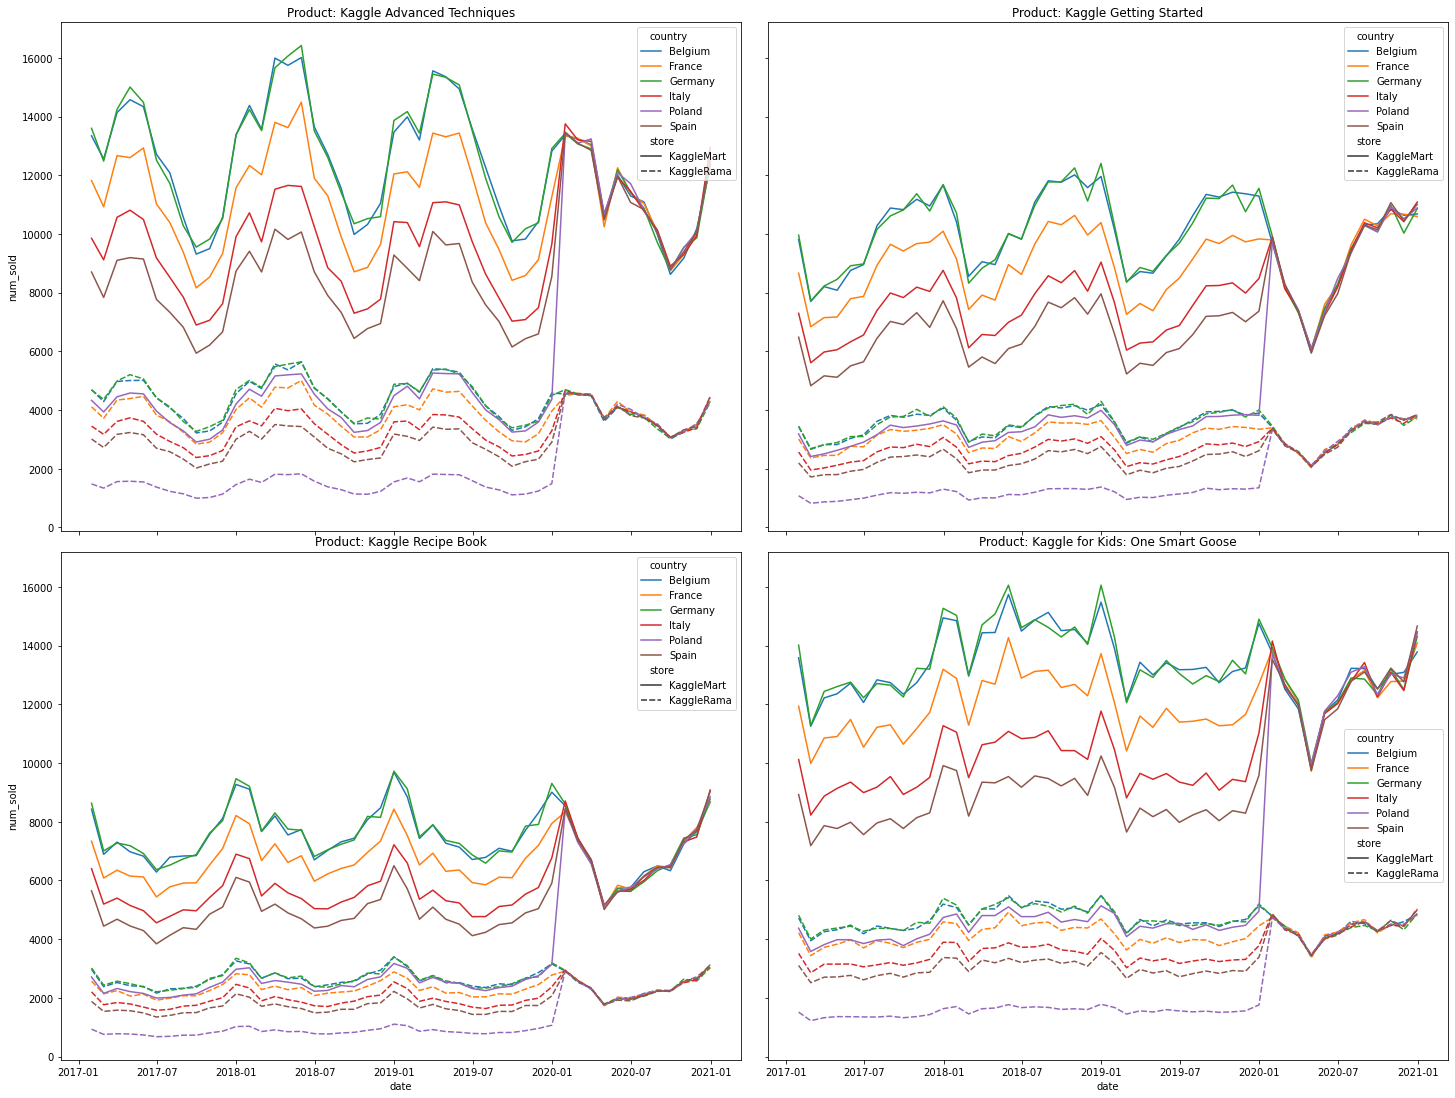

In [20]:
plot_all(monthly_df)

- The year 2020 is significantly different to other years, with sales being almost identical between countries.
- Each product has a different pattern in  number of sales
- It looks a lot like the pattern in sales between stores is identical. With KaggleMart and KaggleRama following the same pattern but with KaggleRama having less sales.
- Similarly it looks like the pattern in sales between all countries is identical, just with the magnitude of sales begin different.

### Aggregating Time Series

#### Store

           date       store  num_sold
0    2017-01-01  KaggleMart  0.736972
1    2017-01-01  KaggleRama  0.263028
2    2017-01-02  KaggleMart  0.739679
3    2017-01-02  KaggleRama  0.260321
4    2017-01-03  KaggleMart  0.741823
...         ...         ...       ...
2917 2020-12-29  KaggleRama  0.263032
2918 2020-12-30  KaggleMart  0.741631
2919 2020-12-30  KaggleRama  0.258369
2920 2020-12-31  KaggleMart  0.738594
2921 2020-12-31  KaggleRama  0.261406

[2922 rows x 3 columns]


Text(0, 0.5, 'Proportion of sales')

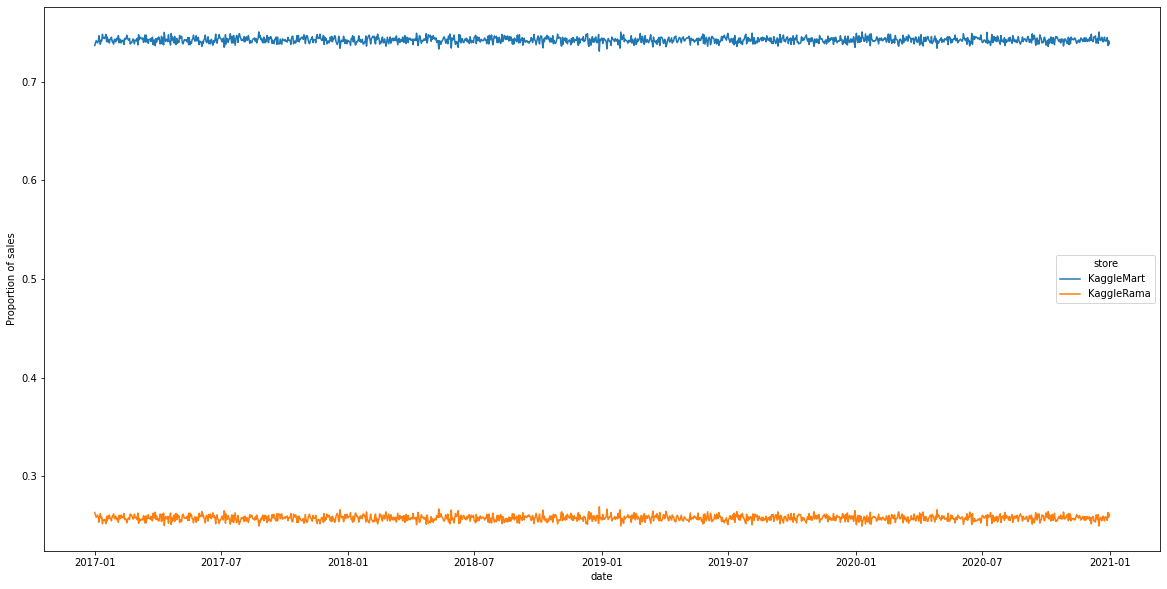

In [33]:
store_weights = train.groupby('store')['num_sold'].sum()/train['num_sold'].sum()
# store_ratio_over_time = 
store_ratio_over_time = (train.groupby(['date', 'store'])['num_sold'].sum()/train.groupby(['date'])['num_sold'].sum()).reset_index()
print(store_ratio_over_time)
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=store_ratio_over_time, x="date", y="num_sold", hue="store")
ax.set_ylabel('Proportion of sales')

KaggleMart appears to consistantly have ~74.25% of the total number of sales. Lets multiply all sales in KaggleRama by a constant so they are compaarable to sales in KaggleMart. If the lines between stores overlap perfectly then trend and seasonality are not unique to the store and we can ignore its effect.

In [39]:
def plot_adjusted(df):
    new_df = train.copy()
    weights = store_weights.loc['KaggleMart']/store_weights
    for store in weights.index:
        new_df.loc[new_df['store'] == store, 'num_sold'] = new_df.loc[new_df['store'] == store, 'num_sold'] * weights[store]
    plot_all(new_df)
        

In [ ]:
plot_adjusted(monthly_df)